# SAR Tutorial

This tutorial shows some of the features of the SAR module. For installation of the tools, please refer to the main [README.md](../README.md). The same data set as for the tools demonstration is used.

The code is based on the [RDKit Cookbook](http://www.rdkit.org/docs/Cookbook.html) and the [paper](https://jcheminf.springeropen.com/articles/10.1186/1758-2946-5-43) by Sereina and Greg.

An example similarity map output is shown [here](./sim_map.html).

**Note:** Some features (like the progressbar) are only correctly displayed when the notebook is actually run, not when it is just displayed in NBviewer. 

In [1]:
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings

import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

try:
    Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
    Draw.DrawingOptions.atomLabelFontSize = 18
except KeyError:  # Font "DejaVu Sans" is not available
    pass

from rdkit_ipynb_tools import tools, pipeline as p, sar

Loading BokehJS ...

misc_tools.apl_tools                          (commit: fa4ebb2 ( 2017-08-10 13:32:35 ))
rdkit_ipynb_tools.tools                       (commit: 8ae2d3f ( 2017-10-25 16:42:41 ))
- no local installation of JSME found, using web version.
> interactive IPython session.
rdkit_ipynb_tools.sar                         (commit: 8ae2d3f ( 2017-10-25 16:42:41 ))


## Example Data Set
Endothelin Receptor A (ET-A) Antagonists from [ChEMBL](https://www.ebi.ac.uk/chembl/), downloaded as tab-separated file on 31-Aug-2016, gzipped.

### Preparation
Count the lines and display the first line

In [2]:
!zcat chembl_et-a_antagonists.txt.gz | wc -l
print()
!zcat chembl_et-a_antagonists.txt.gz | head -n 1

2324

CMPD_CHEMBLID	MOLREGNO	PARENT_CMPD_CHEMBLID	PARENT_MOLREGNO	MOL_PREF_NAME	COMPOUND_KEY	MOLWEIGHT	ALOGP	PSA	NUM_RO5_VIOLATIONS	CANONICAL_SMILES	ACTIVITY_ID	STANDARD_TYPE	RELATION	STANDARD_VALUE	STANDARD_UNITS	PCHEMBL_VALUE	ACTIVITY_COMMENT	DATA_VALIDITY_COMMENT	POTENTIAL_DUPLICATE	BAO_ENDPOINT	UO_UNITS	QUDT_UNITS	ASSAY_ID	ASSAY_CHEMBLID	ASSAY_TYPE	DESCRIPTION	ASSAY_SRC_ID	ASSAY_SRC_DESCRIPTION	ASSAY_ORGANISM	ASSAY_STRAIN	ASSAY_TAX_ID	CURATED_BY	BAO_FORMAT	TID	TARGET_CHEMBLID	TARGET_TYPE	PROTEIN_ACCESSION	PREF_NAME	ORGANISM	CONFIDENCE_SCORE	TARGET_MAPPING	APD_NAME	APD_CONFIDENCE	DOC_ID	DOC_CHEMBLID	PUBMED_ID	JOURNAL	YEAR	VOLUME	ISSUE	FIRST_PAGE	CELL_ID	CELL_CHEMBL_ID	CELL_NAME

gzip: stdout: Broken pipe


We have 2323 records and a number of fields of which we will only need a few.

### Curate the Data Set with Pipelines
Pipelines are part of the tools to deal with arbitrarily large data sets with compound-awareness. This is achieved using Python generators.<br>
We will now use a pipeline to curate the data set for our needs:
1. Read in the data set *(here directly as gzipped file, reading from multiple files is also possible)*
1. Transform the IC50 into a pIC50
1. Keep only the fields that we are interested in
1. Rename a field
1. Generate the structures from Smiles
1. Calculate some physicochemical properties
1. Finally, collect everything in a Mol_List instance

In [3]:
s = p.Summary()  # optional, used for logging what the individual components do

# code for IC50 --> pIC50 conversion
run_code = """rec["ETA_pIC50"] = tools.pic50(rec["STANDARD_VALUE"], "nM")"""  

# define the start of the pipeline, can work directly with gzipped files
rd = p.start_csv_reader("chembl_et-a_antagonists.txt.gz", summary=s)

et_a_list = p.pipe(rd,
             (p.pipe_has_prop_filter, "STANDARD_VALUE", {"summary": s}),
             (p.pipe_custom_man, run_code),
             (p.pipe_keep_props, ["CMPD_CHEMBLID", "CANONICAL_SMILES", "ETA_pIC50"]),
             (p.pipe_rename_prop, "CMPD_CHEMBLID", "Chembl_Id"),
             (p.pipe_mol_from_smiles, "CANONICAL_SMILES"),
             (p.pipe_calc_props, ["2d", "LogP", "MW"]),
             (p.stop_mol_list_from_stream, {"max": 3000, "summary": s})
            )
s.update(True)

## Define Activity Classes and Split the Data Set 
Limit to small molecules:

In [4]:
mol_list = et_a_list.prop_filter("MW <= 500").prop_filter("MW > 300")

  > field MW extracted from query: MW <= 500.
> processed:    1453   found:    621
  > field MW extracted from query: MW > 300.
> processed:     621   found:    593


In [5]:
mol_list.summary()

In [6]:
for mol in mol_list:
    if float(mol.GetProp("ETA_pIC50")) >= 7.0:
        mol.SetProp("AC_Real", "1")
    else:
        mol.SetProp("AC_Real", "0")

In [7]:
train_list, test_list = mol_list.split(0.25)
print(len(train_list), len(test_list))

133 460


## Train the Model

In [8]:
model = sar.train(train_list)

## Prediction
The predicted Activity Class is put in `AC_Pred`, the probability in `Prob`.

In [9]:
test_list = sar.SAR_List(test_list)
test_list.order = ["Chembl_Id", "ETA_pIC50", "AC_Real", "AC_Pred", "Prob", "LogP"]

test_list.model = model

In [10]:
test_list.predict()

The result of the prediction is added as properties `AC_Pred` and `Prob` to the Mol_List:

In [11]:
test_list.summary()

In [12]:
show_props = ["ETA_pIC50", "AC_Real", "AC_Pred", "Prob"]
test_list.grid(props=show_props)

interactive(children=(IntSlider(value=0, description='page', max=38), Output()), _dom_classes=('widget-interact',))

A summary of the success of the prediction:

In [13]:
_ = test_list.analyze()

Number of correctly predicted molecules: 350 / 460    (76.09%)

Correctly predicted molecules per Activity Class:
  0:  81.23
  1:  69.35


## Display as Similarity Maps
The parts of the molecule which contributed to the classification decision can be highlighted with a Similarity Map contour plot. For details please have a look at the paper mentioned in the introduction above.

,ETA:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#,Molecule,SimMap,Chembl_Id,ETA_pIC50,AC_Real,AC_Pred,Prob,LogP
0,,,CHEMBL62112,10.222,1,1,0.98,4.961
1,,,CHEMBL20168,8.481,1,1,0.87,3.616
2,,,CHEMBL80857,7.79,1,1,0.75,4.213
3,,,CHEMBL175045,7.26,1,1,0.81,5.01
4,,,CHEMBL44539,6.67,0,1,0.54,3.558
5,,,CHEMBL269461,6.319,0,1,0.82,3.822
6,,,CHEMBL277595,6.201,0,1,1.0,4.676
7,,,CHEMBL11064,5.939,0,1,0.55,4.601
8,,,CHEMBL170335,4.187,0,0,0.93,3.439
9,,,CHEMBL100120,4.114,0,0,0.98,3.734

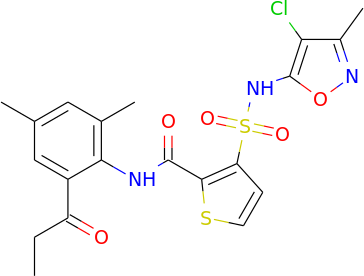
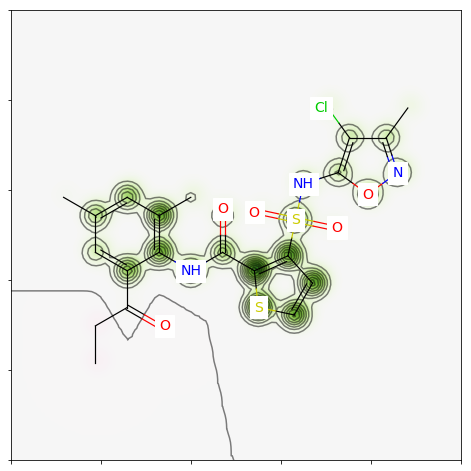
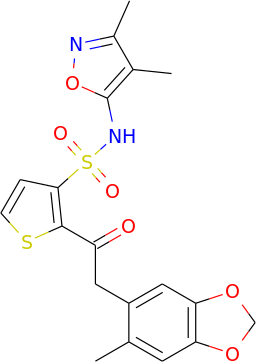
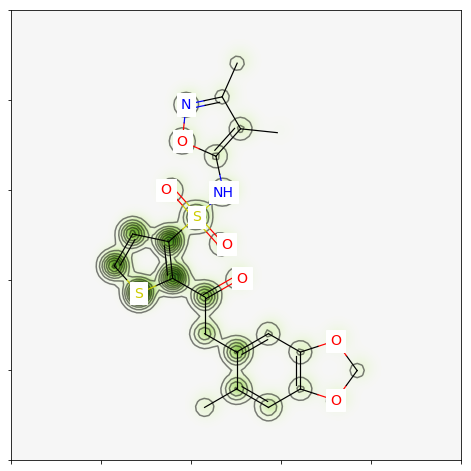
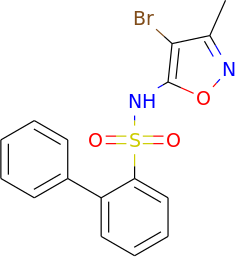
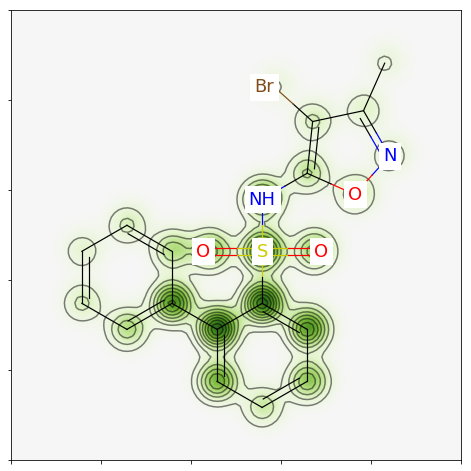
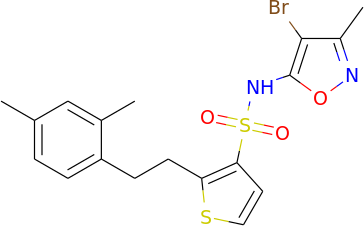
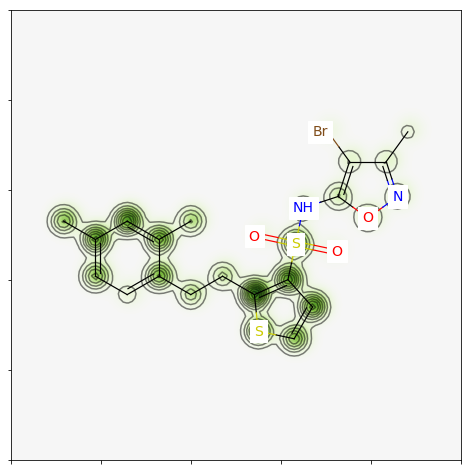
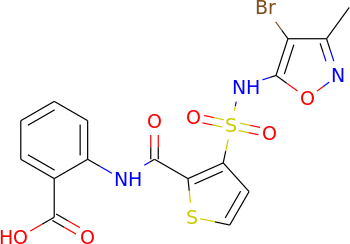
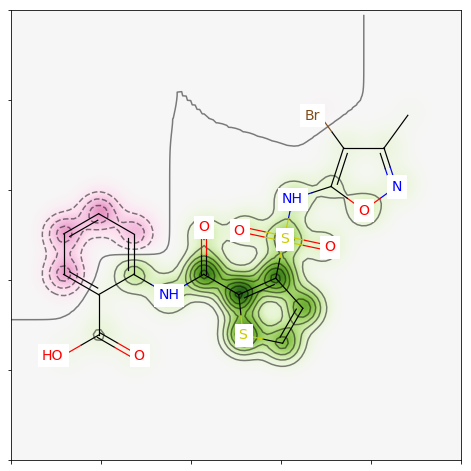
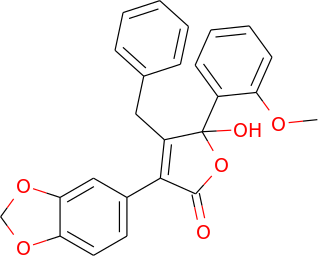
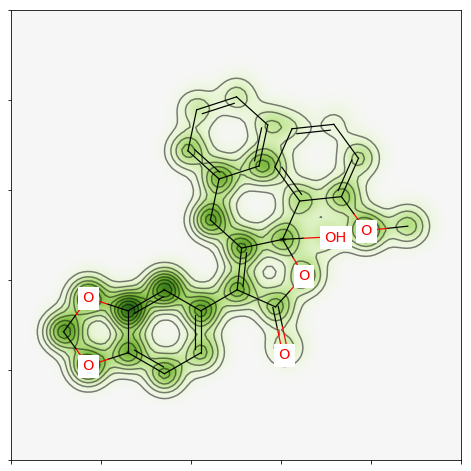
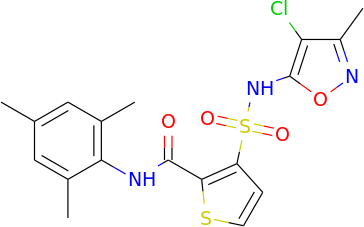
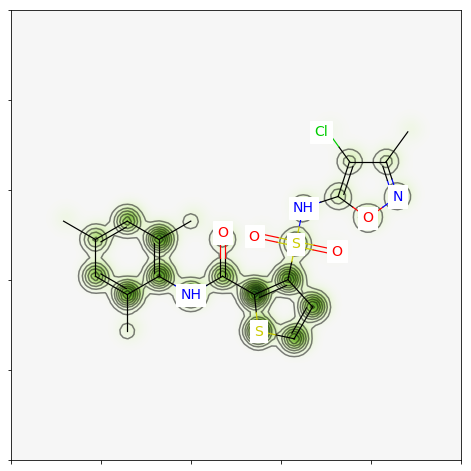
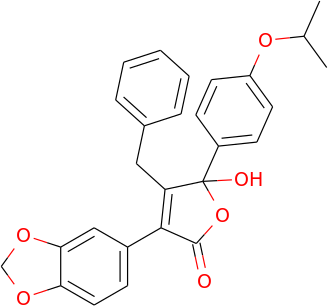
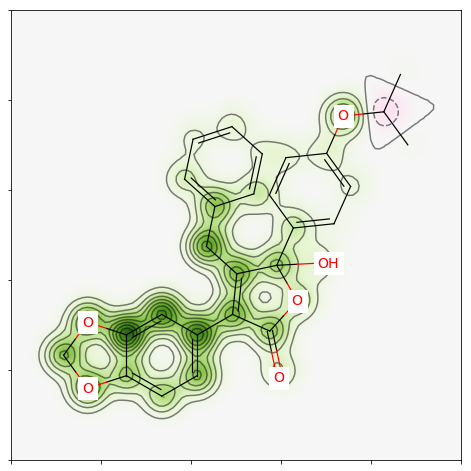
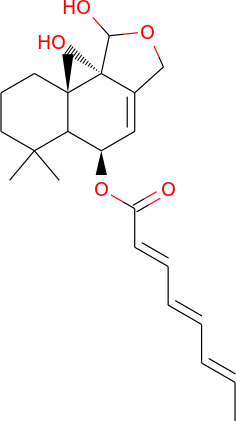
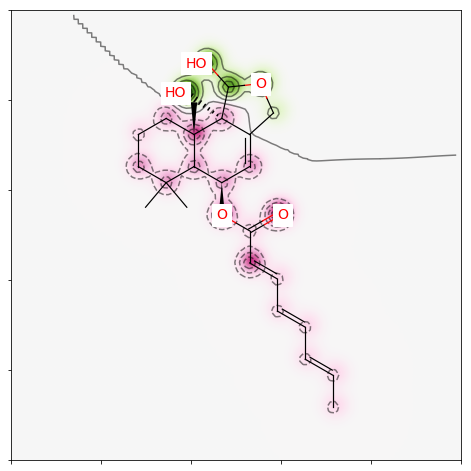
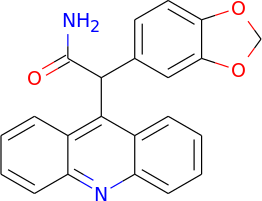
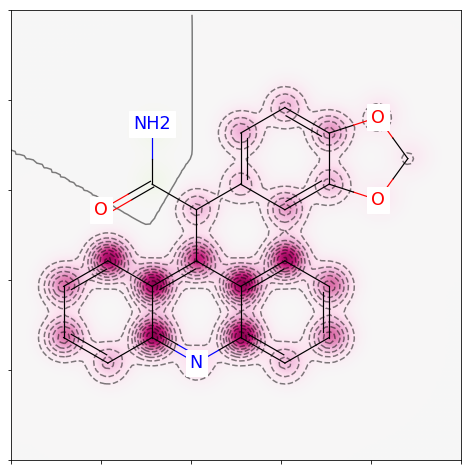

In [14]:
sample_list = test_list.sample_random(10)
sample_list.remove_props("MW")
sample_list.sort_list("ETA_pIC50")
sample_list.sim_map()

In [15]:
sample_list.write_sim_map()

Using cached HTML content...
Set property `html` to `None` to re-generate.
